In [1]:
import ODE_models
import Model_stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import odeint

## Exploring a new payoff


In this notebook we will compare the usual Poletti model to one with altered payoff function. 

$$P_n = -m_n\left(1-(1-q)\left(S_a+I_{Aa}+R_{Aa}\right)\right)\left(\frac{1-p}{p}\right)M - m_nM$$
$$P_a = -k-m_a\left(1-(1-q)\left(S_a+I_{Aa}+R_{Aa}\right)\right)\left(\frac{1-p}{p}\right)M - m_aM$$

Here the $\left(1-(1-q)\left(S_a+I_{Aa}+R_{Aa}\right)\right)\left(\frac{1-p}{p}\right)M$ indicates an individual's perception of how many asymptomatic infected individuals they might encounter. Thus here we are assuming that risk perception decreases as perception of many people observing altered behavior increases.

Note that in this implementation we still have $\frac{1}{m}$ as a parameter where $\frac{1}{m} = \frac{m_n-m_a}{k}$. Then the difference in payoff functions is given by:

$$\Delta P = 1 - m \left(1-(1-q)\left(S_a+I_{Aa}+R_{Aa}\right)\right)\left(\frac{1-p}{p}\right)M - mM$$

Important note: In Poletti's model, the baseline value for $p$ is 1 meaning that there are no asymptomatic individuals. In order for this altered payoff function to be different, we need $p\neq 1$.

### 1.  Baseline parameters

In order to compare this adjusted model with the original Poletti model, we must keep the parameters the same.

In [2]:
recovery_days = 2.8 # average length of infection (current baseline from 2012)
gamma = 1/recovery_days # rate of recovery

beta_S = 0.5 # infection rate for symptomatic infectives
beta_A = 0.5 # infection rate for asymptomatic infectives

q = 0.85  # reduction factor for those with altered/adjusted behavior
p = 1     # probability of developing symptoms

avg_memory = 2.8   # average length of memory regarding active cases
nu  = 1/avg_memory  # rate of forgetting past "new case" counts

M_thresh = 0.01 # risk threshold 
m = 1/M_thresh

rho = 10 # speed of behavioral changes (1/days)

mu = 10**(-8)  # irrational exploration with fixed units

params = ODE_models.get_params(p=0.6)

Now that we know we are using the baseline parameters that were used by Poletti, et. al. (at least in the 2012 paper), we are ready to simulate the model and plot the results. We will chose initial conditions from a reasonable estimation of the early stages of a pandemic.

In [3]:
## Set initial conditions
Sn_0  = (1 - 10**(-3))*(1-10**(-6))
Sa_0  = (1 - 10**(-3))*(10**(-6))
IS_0  = 10**(-3)
IAn_0 = 0
IAa_0 = 0
RS_0  = 0
RAn_0 = 0
RAa_0 = 0
M_0   = 0

# Simulate the ODE
initial_state = np.array([Sn_0,Sa_0,IS_0,IAn_0,IAa_0,RS_0,RAn_0,RAa_0,M_0])
time = np.arange(0,1000,0.005)


# note that we must compare these also with what happens when you consider asymptomatics but not their potential behavior.
sim_system_payoffB = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,True))

#### 1a. Basic Figures to check accuracy

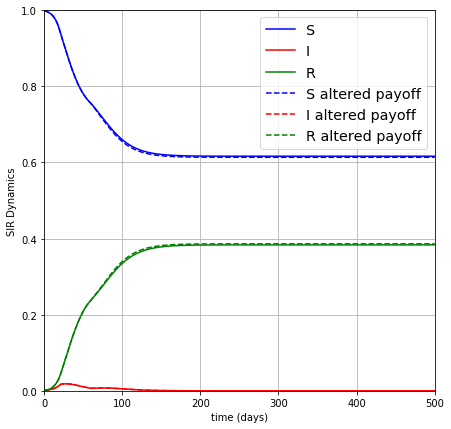

In [4]:
## Plot combined S, I, and R compartments. 

fin_time = 500

matplotlib.rcParams['figure.figsize'] = [7, 7]
fig, ax = plt.subplots()

S = sim_system[:,0]+sim_system[:,1]
I = sim_system[:,2]+sim_system[:,3]+sim_system[:,4]
R = sim_system[:,5]+sim_system[:,6]+sim_system[:,7]

Sb = sim_system_payoffB[:,0]+sim_system_payoffB[:,1]
Ib = sim_system_payoffB[:,2]+sim_system_payoffB[:,3]+sim_system_payoffB[:,4]
Rb = sim_system_payoffB[:,5]+sim_system_payoffB[:,6]+sim_system_payoffB[:,7]

S_curve, = ax.plot(time, S, '-b',label='S')
I_curve, = ax.plot(time, I, '-r',label='I')
R_curve, = ax.plot(time, R, '-g',label='R')

Sb_curve, = ax.plot(time, Sb, '--b',label='S altered payoff')
Ib_curve, = ax.plot(time, Ib, '--r',label='I altered payoff')
Rb_curve, = ax.plot(time, Rb, '--g',label='R altered payoff')

ax.set(xlabel='time (days)', ylabel='SIR Dynamics')
ax.set_ylim((0,1))
ax.set_xlim((0,fin_time))
ax.grid()
ax.legend(loc='best',fontsize='x-large')

Text(0.5, 1.0, 'Poletti Model w/ behavior feedback payoff function')

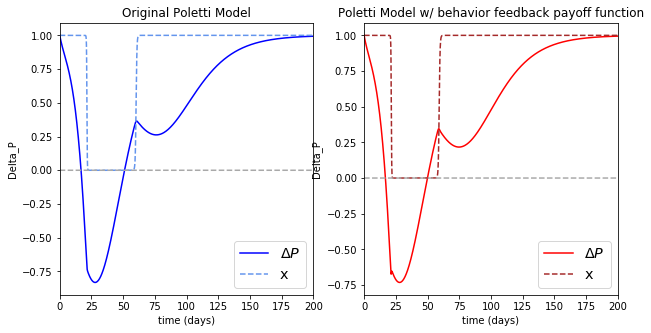

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axes[0]
ax2 = axes[1]

ax1.set(xlabel='time (days)', ylabel='Delta_P')
ax2.set(xlabel='time (days)', ylabel='Delta_P')
#ax.set_ylim((0,0.05))
#ax.set_xlim((0,120))
ax.grid()

delt_Pb = []
delt_P = []
for i in range(len(time)):
    delt_P.append(ODE_models.payoff_difference_asym(sim_system[i,-1],params))
    Pb_out = ODE_models.payoffB_difference(sim_system_payoffB[i,-1],sim_system_payoffB[i,1],
                                           sim_system_payoffB[i,4],sim_system_payoffB[i,7],params)
    delt_Pb.append(Pb_out)
    
nonbehavior_comparts = sim_system[:,2]+sim_system[:,5]
nonbehavior_compartsb = sim_system_payoffB[:,2]+sim_system_payoffB[:,5]

x = (sim_system[:,0]+sim_system[:,3]+sim_system[:,6])/(np.sum(sim_system,axis=1)-nonbehavior_comparts-sim_system[:,-1])
xb = (sim_system_payoffB[:,0]+sim_system_payoffB[:,3]+sim_system_payoffB[:,6])/(np.sum(sim_system_payoffB,axis=1)-nonbehavior_compartsb-sim_system_payoffB[:,-1]) 
    
ax1.plot(time, delt_P, '-b', label=f'$\Delta P$')
ax2.plot(time, delt_Pb, '-r', label=f'$\Delta P$')
ax2.plot(time, xb, '--', c='brown', label='x')
ax1.plot(time, x, '--', c='cornflowerblue', label='x')
ax1.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax2.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax1.set_xlim((0,200))
ax2.set_xlim((0,200))
ax1.legend(loc='lower right',fontsize='x-large')
ax2.legend(loc='lower right',fontsize='x-large')
ax1.set_title('Original Poletti Model')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

### Now we can look at what happens when we vary parameters. 

First of all, we can look at what how this compares to no intervension at all. And we can zoom in on the symptomatic infecteds.

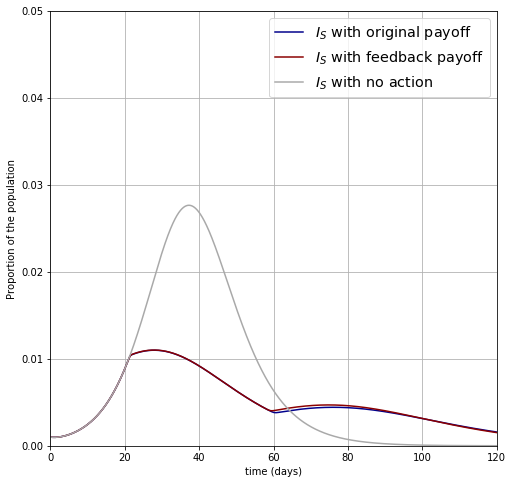

In [6]:
fin_time = 120

matplotlib.rcParams['figure.figsize'] = [8, 8]
fig, ax = plt.subplots()

I_S = sim_system[:,2]
I_Sb = sim_system_payoffB[:,2]

IS_curve, = ax.plot(time, I_S, linestyle='-', c='darkblue', label=f'$I_S$ with original payoff')
ISb_curve, = ax.plot(time, I_Sb, linestyle='-', c='darkred', label=f'$I_S$ with feedback payoff')


# also plot what happens when the population is not responsive. 
params_noresponse = ODE_models.get_params(q=1,p=0.6)
noresponse_sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params_noresponse,))

IS_noresponse = noresponse_sim_system[:,2]
IS_noresponse_curve, = ax.plot(time, IS_noresponse, linestyle='-', c='darkgray', label=f'$I_S$ with no action')

ax.set(xlabel='time (days)', ylabel='Proportion of the population')
ax.set_ylim((0,0.05))
ax.set_xlim((0,fin_time))
ax.grid()
ax.legend(loc='best',fontsize='x-large')

Now we can look at what happens when we vary some of the parameters as we did in Recreate_Poletti.

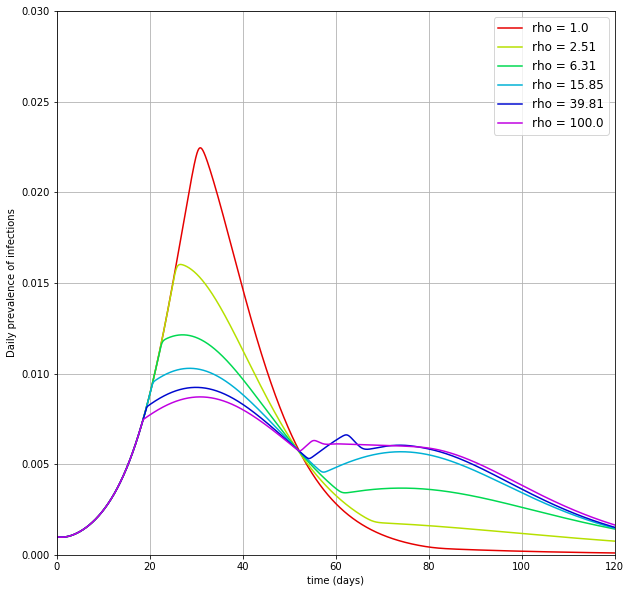

In [7]:
## Keep Poletti baseline but change rho

time = np.arange(0,120,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
ax.set_ylim((0,0.03))
ax.set_xlim((0,120))
ax.grid()

# test a time delay of 2 weeks vs 1 day. 
for i in np.linspace(0,2,6):
    rho_test = 10**i
    params = ODE_models.get_params(p=0.6,rho=rho_test)
    
    sim_system = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
    
    col = next(color_iter)
    #ax.plot(time, sim_system[:,-1], c=col, linestyle='--', label='rho = {}'.format(round(rho_test,2)))
    ax.plot(time, sim_system[:,2], c=col, linestyle='-', label='rho = {}'.format(round(rho_test,2)))
    

ax.legend(loc='best',fontsize='large')

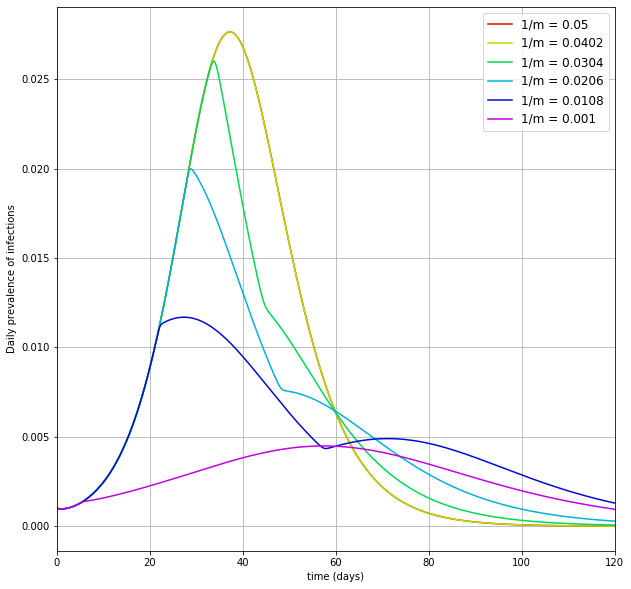

In [8]:
## Keep Poletti baseline but change rho

time = np.arange(0,120,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
#ax.set_ylim((0,0.04))
ax.set_xlim((0,120))
ax.grid()

'''
    Note that even when there is no behavioral change, the peak is only 5/100 people. 
    So... we want to test values for 1/m that make sense and have some affect. 
    I tend to think about it as # of people out of 100 or 1000 or 10000.
    
    Let's test what happens when it's between 5:100 and 1:1000.
'''
for M_thresh_test in np.linspace(0.05,0.001,6):
    
    params = ODE_models.get_params(p=0.6,m=1/M_thresh_test)
    
    sim_system = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
    
    col = next(color_iter)
    #ax.plot(time, sim_system[:,-1], c=col, linestyle='--', label='rho = {}'.format(round(rho_test,2)))
    ax.plot(time, sim_system[:,2], c=col, linestyle='-', label='1/m = {}'.format(round(M_thresh_test,4)))
    

ax.legend(loc='best',fontsize='large')

I'm not sure what happened to the curves for $1/m = 0.05$ or $1/m = 0.042$.

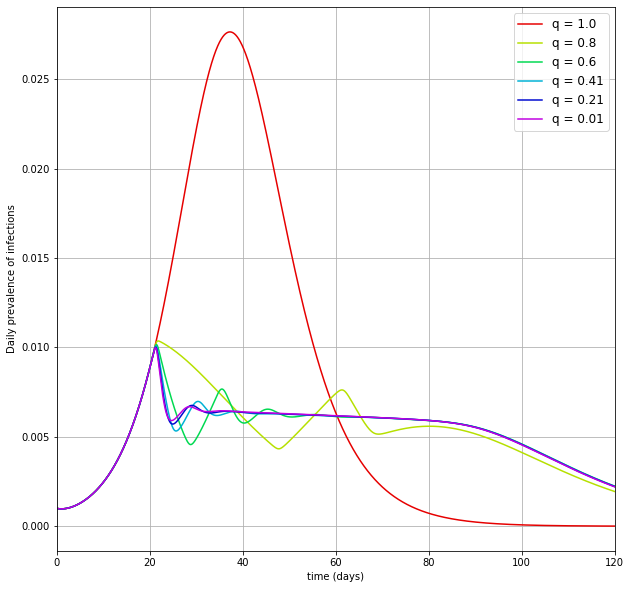

In [9]:
## Keep Poletti baseline but change q

time = np.arange(0,120,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
#ax.set_ylim((0,0.04))
ax.set_xlim((0,120))
ax.grid()

# q has such an important effect and it can really range from 0 to 1. 
# Let's try it all and we can zoom in later. 
for q_test in np.linspace(1,0.01,6):
    
    params = ODE_models.get_params(p=0.6,q=q_test)
    
    sim_system = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
    
    col = next(color_iter)
    #ax.plot(time, sim_system[:,-1], c=col, linestyle='--', label='rho = {}'.format(round(rho_test,2)))
    ax.plot(time, sim_system[:,2], c=col, linestyle='-', label='q = {}'.format(round(q_test,2)))
    

ax.legend(loc='best',fontsize='large')

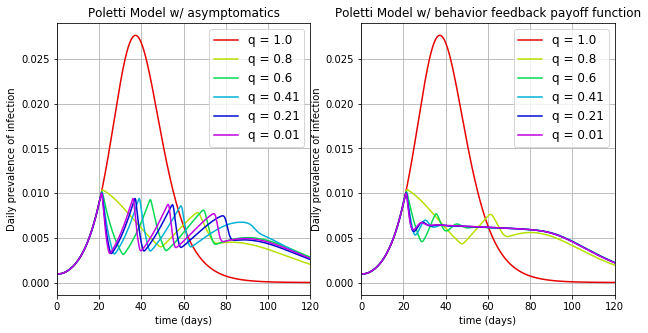

In [23]:
## Keep Poletti baseline but change q

time = np.arange(0,120,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1 = axes[0]
ax2 = axes[1]
ax1.set(xlabel='time (days)', ylabel='Daily prevalence of infection')
ax2.set(xlabel='time (days)', ylabel='Daily prevalence of infection')

#ax.set_ylim((0,0.04))
ax1.set_xlim((0,120))
ax1.grid()
ax2.set_xlim((0,120))
ax2.grid()

# q has such an important effect and it can really range from 0 to 1. 
# Let's try it all and we can zoom in later. 
for q_test in np.linspace(1,0.01,6):
    
    params = ODE_models.get_params(p=0.6,q=q_test)
    
    sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,True))
    sim_systemB = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
    
    col = next(color_iter)
    #ax.plot(time, sim_system[:,-1], c=col, linestyle='--', label='rho = {}'.format(round(rho_test,2)))
    ax1.plot(time, sim_system[:,2], c=col, linestyle='-', label='q = {}'.format(round(q_test,2)))
    ax2.plot(time, sim_systemB[:,2], c=col, linestyle='-', label='q = {}'.format(round(q_test,2)))
    
ax1.set_title('Poletti Model w/ asymptomatics')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

ax1.legend(loc='best',fontsize='large')
ax2.legend(loc='best',fontsize='large')

### Let's look at how the pandemic characteristics change with the contact reduction q. 

In [48]:
## Look at the change in the epidemic characteristics based on changing q

time = np.arange(0,120,0.005)

final_size = []
peak_size = []
peak_day = []

final_sizeb = []
peak_sizeb = []
peak_dayb = []

q_test_set = np.arange(0.1,1.025,0.025)

for q_test in q_test_set:
    
    params = ODE_models.get_params(q=q_test,p=0.6)
    sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,True))
    sim_system_payoff_B = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
    
    final_size.append(Model_stats.final_epi_size(sim_system, time))
    final_sizeb.append(Model_stats.final_epi_size(sim_system_payoff_B, time))
    
    p_day, p_size = Model_stats.daily_peak(sim_system,time,peak_type='all I', data_type='SIR')
    p_dayb, p_sizeb = Model_stats.daily_peak(sim_system_payoff_B,time,peak_type='all I', data_type='SIR')
    peak_size.append(p_size)
    peak_day.append(p_day)
    peak_sizeb.append(p_sizeb)
    peak_dayb.append(p_dayb)

final_size = np.array(final_size)
peak_size = np.array(peak_size)
peak_day = np.array(peak_day)
final_sizeb = np.array(final_sizeb)
peak_sizeb = np.array(peak_sizeb)
peak_dayb = np.array(peak_dayb)

/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


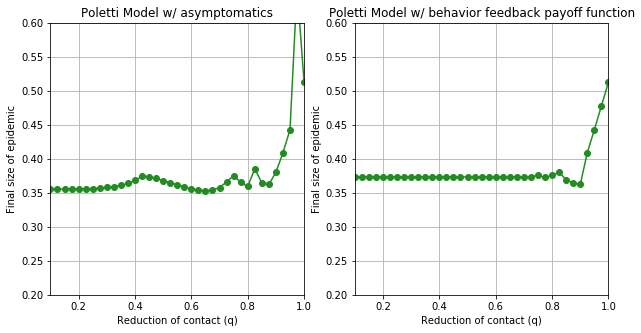

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axes[0]
ax2 = axes[1]
ax1.set(xlabel='Reduction of contact (q)', ylabel='Final size of epidemic')
ax2.set(xlabel='Reduction of contact (q)', ylabel='Final size of epidemic')

ax1.set_title('Poletti Model w/ asymptomatics')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

ax1.set_ylim((0.2,0.6))
ax1.set_xlim((0.1,1))
ax1.grid()
ax2.set_ylim((0.2,0.6))
ax2.set_xlim((0.1,1))
ax2.grid()

ax1.plot(q_test_set, final_size, '-o', c='forestgreen')
ax2.plot(q_test_set, final_sizeb, '-o', c='forestgreen')

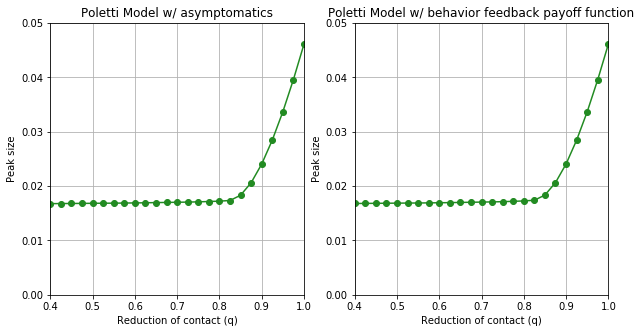

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axes[0]
ax2 = axes[1]
ax1.set(xlabel='Reduction of contact (q)', ylabel='Peak size')
ax2.set(xlabel='Reduction of contact (q)', ylabel='Peak size')

ax1.set_title('Poletti Model w/ asymptomatics')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

ax1.set_ylim((0,0.05))
ax1.set_xlim((0.4,1))
ax1.grid()
ax2.set_ylim((0,0.05))
ax2.set_xlim((0.4,1))
ax2.grid()

ax1.plot(q_test_set, peak_size, '-o', c='forestgreen')
ax2.plot(q_test_set, peak_sizeb, '-o', c='forestgreen')

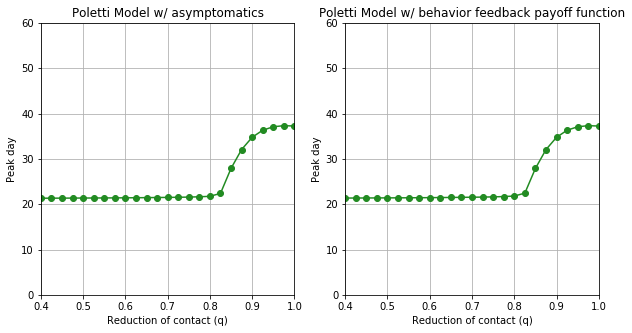

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axes[0]
ax2 = axes[1]
ax1.set(xlabel='Reduction of contact (q)', ylabel='Peak day')
ax2.set(xlabel='Reduction of contact (q)', ylabel='Peak day')

ax1.set_title('Poletti Model w/ asymptomatics')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

ax1.set_ylim((0,60))
ax1.set_xlim((0.4,1))
ax1.grid()
ax2.set_ylim((0,60))
ax2.set_xlim((0.4,1))
ax2.grid()

ax1.plot(q_test_set, peak_day, '-o', c='forestgreen')
ax2.plot(q_test_set, peak_dayb, '-o', c='forestgreen')

#### Let's look at how the payoff function behaves with the contact reduction q.

Text(0.5, 0.98, 'Payoff function for q=0.6')

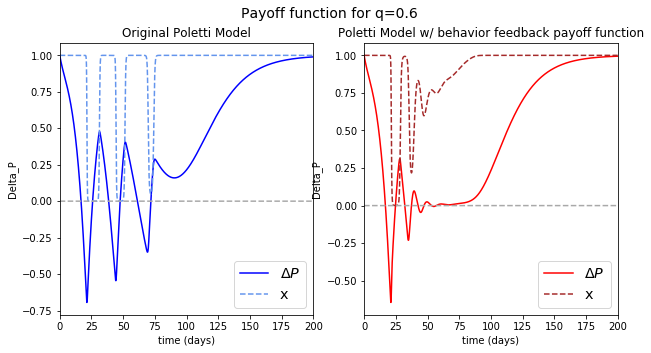

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axes[0]
ax2 = axes[1]

ax1.set(xlabel='time (days)', ylabel='Delta_P')
ax2.set(xlabel='time (days)', ylabel='Delta_P')
#ax.set_ylim((0,0.05))
#ax.set_xlim((0,120))
ax.grid()

time = np.arange(0,200,0.05)

params = ODE_models.get_params(p=0.6,q=0.6)
sim_system_payoffB = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,True))


delt_Pb = []
delt_P = []
for i in range(len(time)):
    delt_P.append(ODE_models.payoff_difference_asym(sim_system[i,-1],params))
    Pb_out = ODE_models.payoffB_difference(sim_system_payoffB[i,-1],sim_system_payoffB[i,1],
                                           sim_system_payoffB[i,4],sim_system_payoffB[i,7],params)
    delt_Pb.append(Pb_out)
    
nonbehavior_comparts = sim_system[:,2]+sim_system[:,5]
nonbehavior_compartsb = sim_system_payoffB[:,2]+sim_system_payoffB[:,5]

x = (sim_system[:,0]+sim_system[:,3]+sim_system[:,6])/(np.sum(sim_system,axis=1)-nonbehavior_comparts-sim_system[:,-1])
xb = (sim_system_payoffB[:,0]+sim_system_payoffB[:,3]+sim_system_payoffB[:,6])/(np.sum(sim_system_payoffB,axis=1)-nonbehavior_compartsb-sim_system_payoffB[:,-1]) 
    
ax1.plot(time, delt_P, '-b', label=f'$\Delta P$')
ax2.plot(time, delt_Pb, '-r', label=f'$\Delta P$')
ax2.plot(time, xb, '--', c='brown', label='x')
ax1.plot(time, x, '--', c='cornflowerblue', label='x')
ax1.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax2.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax1.set_xlim((0,200))
ax2.set_xlim((0,200))
ax1.legend(loc='lower right',fontsize='x-large')
ax2.legend(loc='lower right',fontsize='x-large')
ax1.set_title('Original Poletti Model')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

fig.suptitle('Payoff function for q=0.6', fontsize=14)

Text(0.5, 0.98, 'Payoff function for q=0.7')

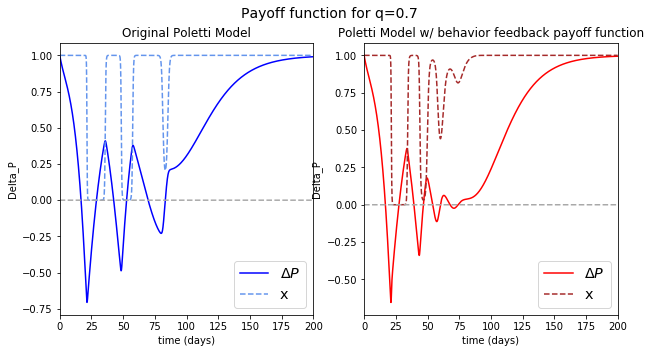

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axes[0]
ax2 = axes[1]

ax1.set(xlabel='time (days)', ylabel='Delta_P')
ax2.set(xlabel='time (days)', ylabel='Delta_P')
#ax.set_ylim((0,0.05))
#ax.set_xlim((0,120))
ax.grid()

time = np.arange(0,200,0.05)

params = ODE_models.get_params(p=0.6,q=0.7)
sim_system_payoffB = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,True))


delt_Pb = []
delt_P = []
for i in range(len(time)):
    delt_P.append(ODE_models.payoff_difference_asym(sim_system[i,-1],params))
    Pb_out = ODE_models.payoffB_difference(sim_system_payoffB[i,-1],sim_system_payoffB[i,1],
                                           sim_system_payoffB[i,4],sim_system_payoffB[i,7],params)
    delt_Pb.append(Pb_out)
    
nonbehavior_comparts = sim_system[:,2]+sim_system[:,5]
nonbehavior_compartsb = sim_system_payoffB[:,2]+sim_system_payoffB[:,5]

x = (sim_system[:,0]+sim_system[:,3]+sim_system[:,6])/(np.sum(sim_system,axis=1)-nonbehavior_comparts-sim_system[:,-1])
xb = (sim_system_payoffB[:,0]+sim_system_payoffB[:,3]+sim_system_payoffB[:,6])/(np.sum(sim_system_payoffB,axis=1)-nonbehavior_compartsb-sim_system_payoffB[:,-1]) 
    
ax1.plot(time, delt_P, '-b', label=f'$\Delta P$')
ax2.plot(time, delt_Pb, '-r', label=f'$\Delta P$')
ax2.plot(time, xb, '--', c='brown', label='x')
ax1.plot(time, x, '--', c='cornflowerblue', label='x')
ax1.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax2.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax1.set_xlim((0,200))
ax2.set_xlim((0,200))
ax1.legend(loc='lower right',fontsize='x-large')
ax2.legend(loc='lower right',fontsize='x-large')
ax1.set_title('Original Poletti Model')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

fig.suptitle('Payoff function for q=0.7', fontsize=14)

Text(0.5, 0.98, 'Payoff function for q=0.8')

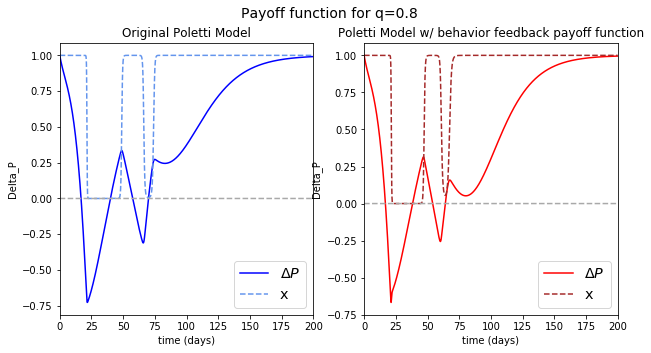

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axes[0]
ax2 = axes[1]

ax1.set(xlabel='time (days)', ylabel='Delta_P')
ax2.set(xlabel='time (days)', ylabel='Delta_P')
#ax.set_ylim((0,0.05))
#ax.set_xlim((0,120))
ax.grid()

time = np.arange(0,200,0.05)

params = ODE_models.get_params(p=0.6,q=0.8)
sim_system_payoffB = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,True))


delt_Pb = []
delt_P = []
for i in range(len(time)):
    delt_P.append(ODE_models.payoff_difference_asym(sim_system[i,-1],params))
    Pb_out = ODE_models.payoffB_difference(sim_system_payoffB[i,-1],sim_system_payoffB[i,1],
                                           sim_system_payoffB[i,4],sim_system_payoffB[i,7],params)
    delt_Pb.append(Pb_out)
    
nonbehavior_comparts = sim_system[:,2]+sim_system[:,5]
nonbehavior_compartsb = sim_system_payoffB[:,2]+sim_system_payoffB[:,5]

x = (sim_system[:,0]+sim_system[:,3]+sim_system[:,6])/(np.sum(sim_system,axis=1)-nonbehavior_comparts-sim_system[:,-1])
xb = (sim_system_payoffB[:,0]+sim_system_payoffB[:,3]+sim_system_payoffB[:,6])/(np.sum(sim_system_payoffB,axis=1)-nonbehavior_compartsb-sim_system_payoffB[:,-1]) 
    
ax1.plot(time, delt_P, '-b', label=f'$\Delta P$')
ax2.plot(time, delt_Pb, '-r', label=f'$\Delta P$')
ax2.plot(time, xb, '--', c='brown', label='x')
ax1.plot(time, x, '--', c='cornflowerblue', label='x')
ax1.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax2.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax1.set_xlim((0,200))
ax2.set_xlim((0,200))
ax1.legend(loc='lower right',fontsize='x-large')
ax2.legend(loc='lower right',fontsize='x-large')
ax1.set_title('Original Poletti Model')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

fig.suptitle('Payoff function for q=0.8', fontsize=14)

Text(0.5, 0.98, 'Payoff function for q=0.9')

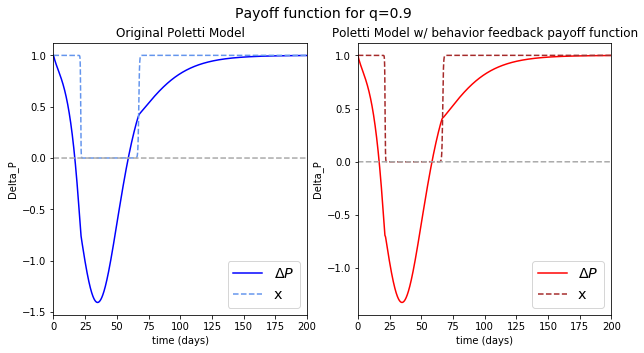

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axes[0]
ax2 = axes[1]

ax1.set(xlabel='time (days)', ylabel='Delta_P')
ax2.set(xlabel='time (days)', ylabel='Delta_P')
#ax.set_ylim((0,0.05))
#ax.set_xlim((0,120))
ax.grid()

time = np.arange(0,200,0.05)

params = ODE_models.get_params(p=0.6,q=0.9)
sim_system_payoffB = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,True))


delt_Pb = []
delt_P = []
for i in range(len(time)):
    delt_P.append(ODE_models.payoff_difference_asym(sim_system[i,-1],params))
    Pb_out = ODE_models.payoffB_difference(sim_system_payoffB[i,-1],sim_system_payoffB[i,1],
                                           sim_system_payoffB[i,4],sim_system_payoffB[i,7],params)
    delt_Pb.append(Pb_out)
    
nonbehavior_comparts = sim_system[:,2]+sim_system[:,5]
nonbehavior_compartsb = sim_system_payoffB[:,2]+sim_system_payoffB[:,5]

x = (sim_system[:,0]+sim_system[:,3]+sim_system[:,6])/(np.sum(sim_system,axis=1)-nonbehavior_comparts-sim_system[:,-1])
xb = (sim_system_payoffB[:,0]+sim_system_payoffB[:,3]+sim_system_payoffB[:,6])/(np.sum(sim_system_payoffB,axis=1)-nonbehavior_compartsb-sim_system_payoffB[:,-1]) 
    
ax1.plot(time, delt_P, '-b', label=f'$\Delta P$')
ax2.plot(time, delt_Pb, '-r', label=f'$\Delta P$')
ax2.plot(time, xb, '--', c='brown', label='x')
ax1.plot(time, x, '--', c='cornflowerblue', label='x')
ax1.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax2.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax1.set_xlim((0,200))
ax2.set_xlim((0,200))
ax1.legend(loc='lower right',fontsize='x-large')
ax2.legend(loc='lower right',fontsize='x-large')
ax1.set_title('Original Poletti Model')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

fig.suptitle('Payoff function for q=0.9', fontsize=14)

Text(0.5, 0.98, 'Payoff function for q=0.5')

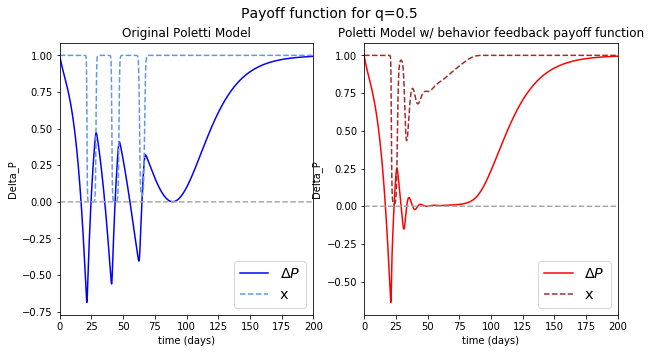

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axes[0]
ax2 = axes[1]

ax1.set(xlabel='time (days)', ylabel='Delta_P')
ax2.set(xlabel='time (days)', ylabel='Delta_P')
#ax.set_ylim((0,0.05))
#ax.set_xlim((0,120))
ax.grid()

time = np.arange(0,200,0.05)

params = ODE_models.get_params(p=0.6,q=0.5)
sim_system_payoffB = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,True))


delt_Pb = []
delt_P = []
for i in range(len(time)):
    delt_P.append(ODE_models.payoff_difference_asym(sim_system[i,-1],params))
    Pb_out = ODE_models.payoffB_difference(sim_system_payoffB[i,-1],sim_system_payoffB[i,1],
                                           sim_system_payoffB[i,4],sim_system_payoffB[i,7],params)
    delt_Pb.append(Pb_out)
    
nonbehavior_comparts = sim_system[:,2]+sim_system[:,5]
nonbehavior_compartsb = sim_system_payoffB[:,2]+sim_system_payoffB[:,5]

x = (sim_system[:,0]+sim_system[:,3]+sim_system[:,6])/(np.sum(sim_system,axis=1)-nonbehavior_comparts-sim_system[:,-1])
xb = (sim_system_payoffB[:,0]+sim_system_payoffB[:,3]+sim_system_payoffB[:,6])/(np.sum(sim_system_payoffB,axis=1)-nonbehavior_compartsb-sim_system_payoffB[:,-1]) 
    
ax1.plot(time, delt_P, '-b', label=f'$\Delta P$')
ax2.plot(time, delt_Pb, '-r', label=f'$\Delta P$')
ax2.plot(time, xb, '--', c='brown', label='x')
ax1.plot(time, x, '--', c='cornflowerblue', label='x')
ax1.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax2.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax1.set_xlim((0,200))
ax2.set_xlim((0,200))
ax1.legend(loc='lower right',fontsize='x-large')
ax2.legend(loc='lower right',fontsize='x-large')
ax1.set_title('Original Poletti Model')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

fig.suptitle('Payoff function for q=0.5', fontsize=14)

Text(0.5, 0.98, 'Payoff function for q=0.4')

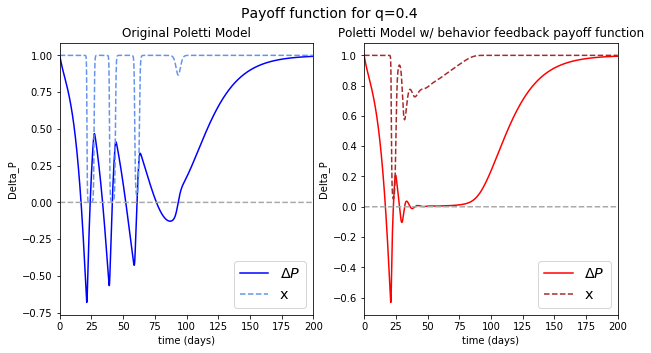

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axes[0]
ax2 = axes[1]

ax1.set(xlabel='time (days)', ylabel='Delta_P')
ax2.set(xlabel='time (days)', ylabel='Delta_P')
#ax.set_ylim((0,0.05))
#ax.set_xlim((0,120))
ax.grid()

time = np.arange(0,200,0.05)

params = ODE_models.get_params(p=0.6,q=0.4)
sim_system_payoffB = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,True))


delt_Pb = []
delt_P = []
for i in range(len(time)):
    delt_P.append(ODE_models.payoff_difference_asym(sim_system[i,-1],params))
    Pb_out = ODE_models.payoffB_difference(sim_system_payoffB[i,-1],sim_system_payoffB[i,1],
                                           sim_system_payoffB[i,4],sim_system_payoffB[i,7],params)
    delt_Pb.append(Pb_out)
    
nonbehavior_comparts = sim_system[:,2]+sim_system[:,5]
nonbehavior_compartsb = sim_system_payoffB[:,2]+sim_system_payoffB[:,5]

x = (sim_system[:,0]+sim_system[:,3]+sim_system[:,6])/(np.sum(sim_system,axis=1)-nonbehavior_comparts-sim_system[:,-1])
xb = (sim_system_payoffB[:,0]+sim_system_payoffB[:,3]+sim_system_payoffB[:,6])/(np.sum(sim_system_payoffB,axis=1)-nonbehavior_compartsb-sim_system_payoffB[:,-1]) 
    
ax1.plot(time, delt_P, '-b', label=f'$\Delta P$')
ax2.plot(time, delt_Pb, '-r', label=f'$\Delta P$')
ax2.plot(time, xb, '--', c='brown', label='x')
ax1.plot(time, x, '--', c='cornflowerblue', label='x')
ax1.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax2.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax1.set_xlim((0,200))
ax2.set_xlim((0,200))
ax1.legend(loc='lower right',fontsize='x-large')
ax2.legend(loc='lower right',fontsize='x-large')
ax1.set_title('Original Poletti Model')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

fig.suptitle('Payoff function for q=0.4', fontsize=14)

Text(0.5, 0.98, 'Payoff function for q=0.3')

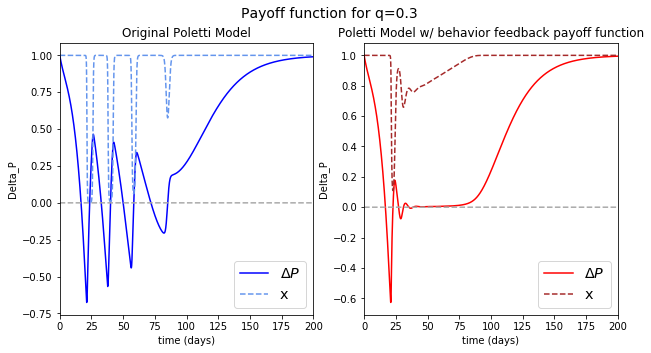

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axes[0]
ax2 = axes[1]

ax1.set(xlabel='time (days)', ylabel='Delta_P')
ax2.set(xlabel='time (days)', ylabel='Delta_P')
#ax.set_ylim((0,0.05))
#ax.set_xlim((0,120))
ax.grid()

time = np.arange(0,200,0.05)

params = ODE_models.get_params(p=0.6,q=0.3)
sim_system_payoffB = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,True))


delt_Pb = []
delt_P = []
for i in range(len(time)):
    delt_P.append(ODE_models.payoff_difference_asym(sim_system[i,-1],params))
    Pb_out = ODE_models.payoffB_difference(sim_system_payoffB[i,-1],sim_system_payoffB[i,1],
                                           sim_system_payoffB[i,4],sim_system_payoffB[i,7],params)
    delt_Pb.append(Pb_out)
    
nonbehavior_comparts = sim_system[:,2]+sim_system[:,5]
nonbehavior_compartsb = sim_system_payoffB[:,2]+sim_system_payoffB[:,5]

x = (sim_system[:,0]+sim_system[:,3]+sim_system[:,6])/(np.sum(sim_system,axis=1)-nonbehavior_comparts-sim_system[:,-1])
xb = (sim_system_payoffB[:,0]+sim_system_payoffB[:,3]+sim_system_payoffB[:,6])/(np.sum(sim_system_payoffB,axis=1)-nonbehavior_compartsb-sim_system_payoffB[:,-1]) 
    
ax1.plot(time, delt_P, '-b', label=f'$\Delta P$')
ax2.plot(time, delt_Pb, '-r', label=f'$\Delta P$')
ax2.plot(time, xb, '--', c='brown', label='x')
ax1.plot(time, x, '--', c='cornflowerblue', label='x')
ax1.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax2.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax1.set_xlim((0,200))
ax2.set_xlim((0,200))
ax1.legend(loc='lower right',fontsize='x-large')
ax2.legend(loc='lower right',fontsize='x-large')
ax1.set_title('Original Poletti Model')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

fig.suptitle('Payoff function for q=0.3', fontsize=14)

Text(0.5, 0.98, 'Payoff function for q=0.2')

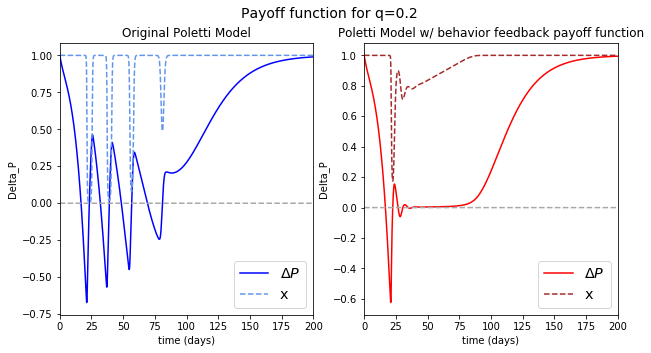

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axes[0]
ax2 = axes[1]

ax1.set(xlabel='time (days)', ylabel='Delta_P')
ax2.set(xlabel='time (days)', ylabel='Delta_P')
#ax.set_ylim((0,0.05))
#ax.set_xlim((0,120))
ax.grid()

time = np.arange(0,200,0.05)

params = ODE_models.get_params(p=0.6,q=0.2)
sim_system_payoffB = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,True))


delt_Pb = []
delt_P = []
for i in range(len(time)):
    delt_P.append(ODE_models.payoff_difference_asym(sim_system[i,-1],params))
    Pb_out = ODE_models.payoffB_difference(sim_system_payoffB[i,-1],sim_system_payoffB[i,1],
                                           sim_system_payoffB[i,4],sim_system_payoffB[i,7],params)
    delt_Pb.append(Pb_out)
    
nonbehavior_comparts = sim_system[:,2]+sim_system[:,5]
nonbehavior_compartsb = sim_system_payoffB[:,2]+sim_system_payoffB[:,5]

x = (sim_system[:,0]+sim_system[:,3]+sim_system[:,6])/(np.sum(sim_system,axis=1)-nonbehavior_comparts-sim_system[:,-1])
xb = (sim_system_payoffB[:,0]+sim_system_payoffB[:,3]+sim_system_payoffB[:,6])/(np.sum(sim_system_payoffB,axis=1)-nonbehavior_compartsb-sim_system_payoffB[:,-1]) 
    
ax1.plot(time, delt_P, '-b', label=f'$\Delta P$')
ax2.plot(time, delt_Pb, '-r', label=f'$\Delta P$')
ax2.plot(time, xb, '--', c='brown', label='x')
ax1.plot(time, x, '--', c='cornflowerblue', label='x')
ax1.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax2.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax1.set_xlim((0,200))
ax2.set_xlim((0,200))
ax1.legend(loc='lower right',fontsize='x-large')
ax2.legend(loc='lower right',fontsize='x-large')
ax1.set_title('Original Poletti Model')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

fig.suptitle('Payoff function for q=0.2', fontsize=14)

### Let's look how it changes with the rate of asymptomatic p. 

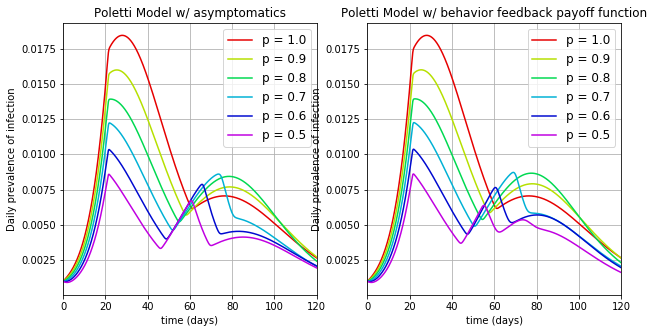

In [29]:
## Keep Poletti baseline but change q

time = np.arange(0,120,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1 = axes[0]
ax2 = axes[1]
ax1.set(xlabel='time (days)', ylabel='Daily prevalence of infection')
ax2.set(xlabel='time (days)', ylabel='Daily prevalence of infection')

#ax.set_ylim((0,0.04))
ax1.set_xlim((0,120))
ax1.grid()
ax2.set_xlim((0,120))
ax2.grid()


for p_test in np.linspace(1,0.5,6):
    
    params = ODE_models.get_params(p=p_test,q=0.8)
    
    sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,True))
    sim_systemB = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
    
    col = next(color_iter)
    #ax.plot(time, sim_system[:,-1], c=col, linestyle='--', label='rho = {}'.format(round(rho_test,2)))
    ax1.plot(time, sim_system[:,2], c=col, linestyle='-', label='p = {}'.format(round(p_test,2)))
    ax2.plot(time, sim_systemB[:,2], c=col, linestyle='-', label='p = {}'.format(round(p_test,2)))
    
ax1.set_title('Poletti Model w/ asymptomatics')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

ax1.legend(loc='best',fontsize='large')
ax2.legend(loc='best',fontsize='large')

In [52]:
## Look at the change in the epidemic characteristics based on changing q

time = np.arange(0,120,0.005)

final_size = []
peak_size = []
peak_day = []

final_sizeb = []
peak_sizeb = []
peak_dayb = []

p_test_set = np.arange(0.5,1.025,0.025)

for p_test in p_test_set:
    
    params = ODE_models.get_params(q=0.8,p=p_test)
    sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,True))
    sim_system_payoff_B = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
    
    final_size.append(Model_stats.final_epi_size(sim_system, time))
    final_sizeb.append(Model_stats.final_epi_size(sim_system_payoff_B, time))
    
    p_day, p_size = Model_stats.daily_peak(sim_system,time,peak_type='all I', data_type='SIR')
    p_dayb, p_sizeb = Model_stats.daily_peak(sim_system_payoff_B,time,peak_type='all I', data_type='SIR')
    peak_size.append(p_size)
    peak_day.append(p_day)
    peak_sizeb.append(p_sizeb)
    peak_dayb.append(p_dayb)

final_size = np.array(final_size)
peak_size = np.array(peak_size)
peak_day = np.array(peak_day)
final_sizeb = np.array(final_sizeb)
peak_sizeb = np.array(peak_sizeb)
peak_dayb = np.array(peak_dayb)

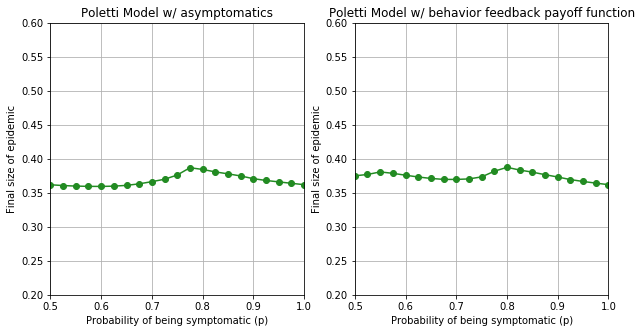

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axes[0]
ax2 = axes[1]
ax1.set(xlabel='Probability of being symptomatic (p)', ylabel='Final size of epidemic')
ax2.set(xlabel='Probability of being symptomatic (p)', ylabel='Final size of epidemic')

ax1.set_title('Poletti Model w/ asymptomatics')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

ax1.set_ylim((0.2,0.6))
ax1.set_xlim((0.5,1))
ax1.grid()
ax2.set_ylim((0.2,0.6))
ax2.set_xlim((0.5,1))
ax2.grid()

ax1.plot(p_test_set, final_size, '-o', c='forestgreen')
ax2.plot(p_test_set, final_sizeb, '-o', c='forestgreen')

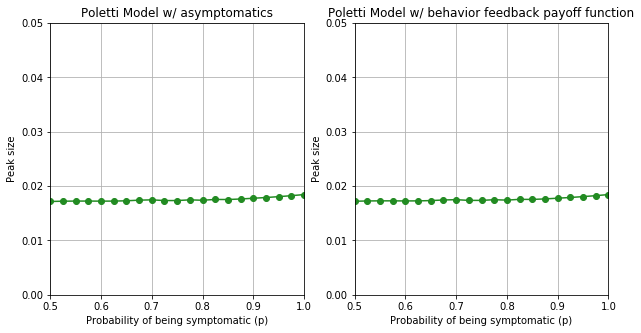

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axes[0]
ax2 = axes[1]
ax1.set(xlabel='Probability of being symptomatic (p)', ylabel='Peak size')
ax2.set(xlabel='Probability of being symptomatic (p)', ylabel='Peak size')

ax1.set_title('Poletti Model w/ asymptomatics')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

ax1.set_ylim((0,0.05))
ax1.set_xlim((0.5,1))
ax1.grid()
ax2.set_ylim((0,0.05))
ax2.set_xlim((0.5,1))
ax2.grid()

ax1.plot(p_test_set, peak_size, '-o', c='forestgreen')
ax2.plot(p_test_set, peak_sizeb, '-o', c='forestgreen')

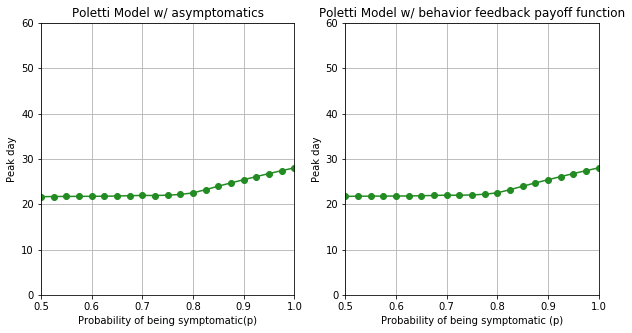

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axes[0]
ax2 = axes[1]
ax1.set(xlabel='Probability of being symptomatic(p)', ylabel='Peak day')
ax2.set(xlabel='Probability of being symptomatic (p)', ylabel='Peak day')

ax1.set_title('Poletti Model w/ asymptomatics')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

ax1.set_ylim((0,60))
ax1.set_xlim((0.5,1))
ax1.grid()
ax2.set_ylim((0,60))
ax2.set_xlim((0.5,1))
ax2.grid()

ax1.plot(p_test_set, peak_day, '-o', c='forestgreen')
ax2.plot(p_test_set, peak_dayb, '-o', c='forestgreen')

#### Let's look at how the payoff function behaves with the probability of being symptomatic (p).

Text(0.5, 0.98, 'Payoff function for p=0.5')

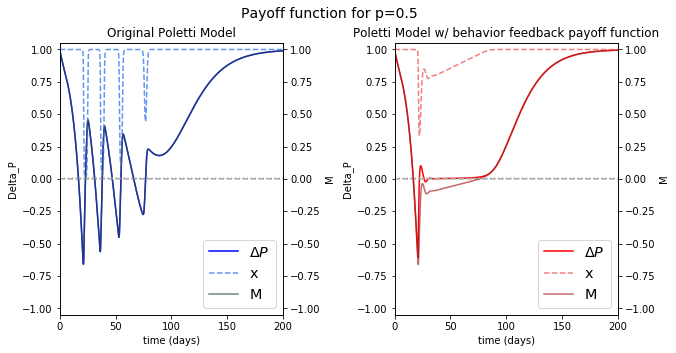

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.5)

ax1 = axes[0]
ax2 = axes[1]

ax1.set(xlabel='time (days)', ylabel='Delta_P')
ax2.set(xlabel='time (days)', ylabel='Delta_P')
#ax.set_ylim((0,0.05))
#ax.set_xlim((0,120))
ax.grid()

time = np.arange(0,200,0.05)

params = ODE_models.get_params(p=0.5,q=0.1)
sim_system_payoffB = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,True))


delt_Pb = []
delt_P = []
for i in range(len(time)):
    delt_P.append(ODE_models.payoff_difference_asym(sim_system[i,-1],params))
    Pb_out = ODE_models.payoffB_difference(sim_system_payoffB[i,-1],sim_system_payoffB[i,1],
                                           sim_system_payoffB[i,4],sim_system_payoffB[i,7],params)
    delt_Pb.append(Pb_out)
    
nonbehavior_comparts = sim_system[:,2]+sim_system[:,5]
nonbehavior_compartsb = sim_system_payoffB[:,2]+sim_system_payoffB[:,5]

x = (sim_system[:,0]+sim_system[:,3]+sim_system[:,6])/(np.sum(sim_system,axis=1)-nonbehavior_comparts-sim_system[:,-1])
xb = (sim_system_payoffB[:,0]+sim_system_payoffB[:,3]+sim_system_payoffB[:,6])/(np.sum(sim_system_payoffB,axis=1)-nonbehavior_compartsb-sim_system_payoffB[:,-1]) 
    
dp1, = ax1.plot(time, delt_P, '-b', label=f'$\Delta P$')
dp2, = ax2.plot(time, delt_Pb, '-r', label=f'$\Delta P$')
b1, = ax1.plot(time, x, '--', c='cornflowerblue', label='x')
b2, = ax2.plot(time, xb, '--', c='lightcoral', label='x')
ax1.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax2.plot(time, np.zeros(len(time)), '--', c='darkgray')

ax1a = ax1.twinx()
ax2a = ax2.twinx()
p = params[4]
m = params[6]
M1, = ax1a.plot(time, np.ones(len(time))-(m/p)*sim_system[:,-1],'-', c='darkslategray', label='M', alpha=0.7)
M2, = ax2a.plot(time, np.ones(len(time))-(m/p)*sim_system_payoffB[:,-1],'-', c='brown', label='M', alpha=0.7)
ax1a.set(ylabel = 'M')
ax2a.set(ylabel = 'M')
#ax1a.set_ylim((-0.03,0.05))
#ax2a.set_ylim((-0.03,0.05))
ax1a.plot(time, p*np.ones(len(time))/m, ':', c='darkgray')
ax2a.plot(time, p*np.ones(len(time))/m, ':', c='darkgray')

ax1.set_xlim((0,200))
ax2.set_xlim((0,200))
ax1.set_ylim((-1.05,1.05))
ax2.set_ylim((-1.05,1.05))
ax1a.set_ylim((-1.05,1.05))
ax2a.set_ylim((-1.05,1.05))

lns1 = [dp1,b1,M1]
labs1 = [l.get_label() for l in lns1]
ax1.legend(lns1, labs1, loc='best',fontsize='x-large')
lns2 = [dp2,b2,M2]
labs2 = [l.get_label() for l in lns2]
ax2.legend(lns2, labs2, loc='best',fontsize='x-large')

ax1.set_title('Original Poletti Model')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

fig.suptitle('Payoff function for p=0.5', fontsize=14)

Text(0.5, 0.98, 'Payoff function for p=0.6')

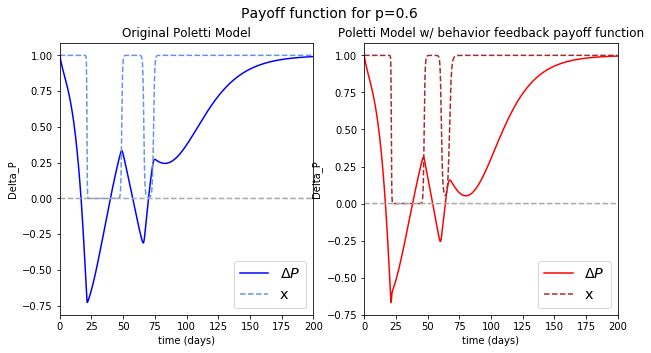

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axes[0]
ax2 = axes[1]

ax1.set(xlabel='time (days)', ylabel='Delta_P')
ax2.set(xlabel='time (days)', ylabel='Delta_P')
#ax.set_ylim((0,0.05))
#ax.set_xlim((0,120))
ax.grid()

time = np.arange(0,200,0.05)

params = ODE_models.get_params(p=0.6,q=0.8)
sim_system_payoffB = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,True))


delt_Pb = []
delt_P = []
for i in range(len(time)):
    delt_P.append(ODE_models.payoff_difference_asym(sim_system[i,-1],params))
    Pb_out = ODE_models.payoffB_difference(sim_system_payoffB[i,-1],sim_system_payoffB[i,1],
                                           sim_system_payoffB[i,4],sim_system_payoffB[i,7],params)
    delt_Pb.append(Pb_out)
    
nonbehavior_comparts = sim_system[:,2]+sim_system[:,5]
nonbehavior_compartsb = sim_system_payoffB[:,2]+sim_system_payoffB[:,5]

x = (sim_system[:,0]+sim_system[:,3]+sim_system[:,6])/(np.sum(sim_system,axis=1)-nonbehavior_comparts-sim_system[:,-1])
xb = (sim_system_payoffB[:,0]+sim_system_payoffB[:,3]+sim_system_payoffB[:,6])/(np.sum(sim_system_payoffB,axis=1)-nonbehavior_compartsb-sim_system_payoffB[:,-1]) 
    
ax1.plot(time, delt_P, '-b', label=f'$\Delta P$')
ax2.plot(time, delt_Pb, '-r', label=f'$\Delta P$')
ax2.plot(time, xb, '--', c='brown', label='x')
ax1.plot(time, x, '--', c='cornflowerblue', label='x')
ax1.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax2.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax1.set_xlim((0,200))
ax2.set_xlim((0,200))
ax1.legend(loc='lower right',fontsize='x-large')
ax2.legend(loc='lower right',fontsize='x-large')
ax1.set_title('Original Poletti Model')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

fig.suptitle('Payoff function for p=0.6', fontsize=14)

Text(0.5, 0.98, 'Payoff function for p=0.7')

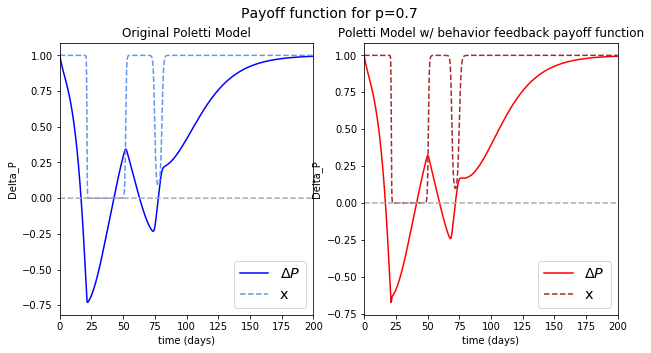

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axes[0]
ax2 = axes[1]

ax1.set(xlabel='time (days)', ylabel='Delta_P')
ax2.set(xlabel='time (days)', ylabel='Delta_P')
#ax.set_ylim((0,0.05))
#ax.set_xlim((0,120))
ax.grid()

time = np.arange(0,200,0.05)

params = ODE_models.get_params(p=0.7,q=0.8)
sim_system_payoffB = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,True))


delt_Pb = []
delt_P = []
for i in range(len(time)):
    delt_P.append(ODE_models.payoff_difference_asym(sim_system[i,-1],params))
    Pb_out = ODE_models.payoffB_difference(sim_system_payoffB[i,-1],sim_system_payoffB[i,1],
                                           sim_system_payoffB[i,4],sim_system_payoffB[i,7],params)
    delt_Pb.append(Pb_out)
    
nonbehavior_comparts = sim_system[:,2]+sim_system[:,5]
nonbehavior_compartsb = sim_system_payoffB[:,2]+sim_system_payoffB[:,5]

x = (sim_system[:,0]+sim_system[:,3]+sim_system[:,6])/(np.sum(sim_system,axis=1)-nonbehavior_comparts-sim_system[:,-1])
xb = (sim_system_payoffB[:,0]+sim_system_payoffB[:,3]+sim_system_payoffB[:,6])/(np.sum(sim_system_payoffB,axis=1)-nonbehavior_compartsb-sim_system_payoffB[:,-1]) 
    
ax1.plot(time, delt_P, '-b', label=f'$\Delta P$')
ax2.plot(time, delt_Pb, '-r', label=f'$\Delta P$')
ax2.plot(time, xb, '--', c='brown', label='x')
ax1.plot(time, x, '--', c='cornflowerblue', label='x')
ax1.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax2.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax1.set_xlim((0,200))
ax2.set_xlim((0,200))
ax1.legend(loc='lower right',fontsize='x-large')
ax2.legend(loc='lower right',fontsize='x-large')
ax1.set_title('Original Poletti Model')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

fig.suptitle('Payoff function for p=0.7', fontsize=14)

Text(0.5, 0.98, 'Payoff function for p=0.8')

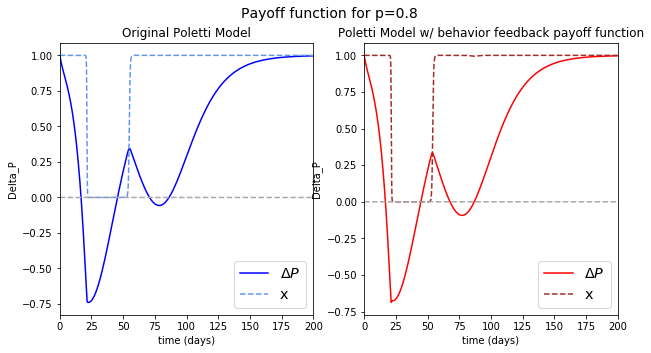

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axes[0]
ax2 = axes[1]

ax1.set(xlabel='time (days)', ylabel='Delta_P')
ax2.set(xlabel='time (days)', ylabel='Delta_P')
#ax.set_ylim((0,0.05))
#ax.set_xlim((0,120))
ax.grid()

time = np.arange(0,200,0.05)

params = ODE_models.get_params(p=0.8,q=0.8)
sim_system_payoffB = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,True))


delt_Pb = []
delt_P = []
for i in range(len(time)):
    delt_P.append(ODE_models.payoff_difference_asym(sim_system[i,-1],params))
    Pb_out = ODE_models.payoffB_difference(sim_system_payoffB[i,-1],sim_system_payoffB[i,1],
                                           sim_system_payoffB[i,4],sim_system_payoffB[i,7],params)
    delt_Pb.append(Pb_out)
    
nonbehavior_comparts = sim_system[:,2]+sim_system[:,5]
nonbehavior_compartsb = sim_system_payoffB[:,2]+sim_system_payoffB[:,5]

x = (sim_system[:,0]+sim_system[:,3]+sim_system[:,6])/(np.sum(sim_system,axis=1)-nonbehavior_comparts-sim_system[:,-1])
xb = (sim_system_payoffB[:,0]+sim_system_payoffB[:,3]+sim_system_payoffB[:,6])/(np.sum(sim_system_payoffB,axis=1)-nonbehavior_compartsb-sim_system_payoffB[:,-1]) 
    
ax1.plot(time, delt_P, '-b', label=f'$\Delta P$')
ax2.plot(time, delt_Pb, '-r', label=f'$\Delta P$')
ax2.plot(time, xb, '--', c='brown', label='x')
ax1.plot(time, x, '--', c='cornflowerblue', label='x')
ax1.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax2.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax1.set_xlim((0,200))
ax2.set_xlim((0,200))
ax1.legend(loc='lower right',fontsize='x-large')
ax2.legend(loc='lower right',fontsize='x-large')
ax1.set_title('Original Poletti Model')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

fig.suptitle('Payoff function for p=0.8', fontsize=14)

Text(0.5, 0.98, 'Payoff function for p=0.9')

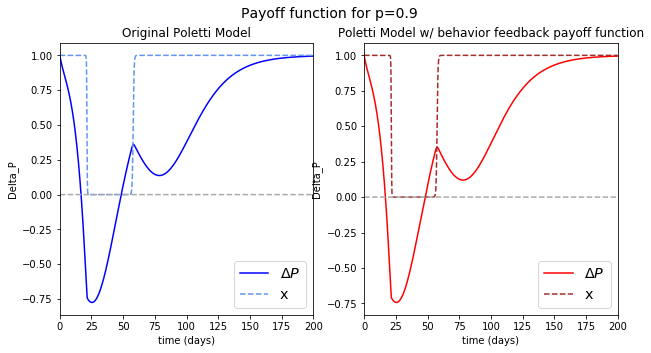

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = axes[0]
ax2 = axes[1]

ax1.set(xlabel='time (days)', ylabel='Delta_P')
ax2.set(xlabel='time (days)', ylabel='Delta_P')
#ax.set_ylim((0,0.05))
#ax.set_xlim((0,120))
ax.grid()

time = np.arange(0,200,0.05)

params = ODE_models.get_params(p=0.9,q=0.8)
sim_system_payoffB = odeint(ODE_models.SIRan_system_payoffB, initial_state, time, args=(params,))
sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,True))


delt_Pb = []
delt_P = []
for i in range(len(time)):
    delt_P.append(ODE_models.payoff_difference_asym(sim_system[i,-1],params))
    Pb_out = ODE_models.payoffB_difference(sim_system_payoffB[i,-1],sim_system_payoffB[i,1],
                                           sim_system_payoffB[i,4],sim_system_payoffB[i,7],params)
    delt_Pb.append(Pb_out)
    
nonbehavior_comparts = sim_system[:,2]+sim_system[:,5]
nonbehavior_compartsb = sim_system_payoffB[:,2]+sim_system_payoffB[:,5]

x = (sim_system[:,0]+sim_system[:,3]+sim_system[:,6])/(np.sum(sim_system,axis=1)-nonbehavior_comparts-sim_system[:,-1])
xb = (sim_system_payoffB[:,0]+sim_system_payoffB[:,3]+sim_system_payoffB[:,6])/(np.sum(sim_system_payoffB,axis=1)-nonbehavior_compartsb-sim_system_payoffB[:,-1]) 
    
ax1.plot(time, delt_P, '-b', label=f'$\Delta P$')
ax2.plot(time, delt_Pb, '-r', label=f'$\Delta P$')
ax2.plot(time, xb, '--', c='brown', label='x')
ax1.plot(time, x, '--', c='cornflowerblue', label='x')
ax1.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax2.plot(time, np.zeros(len(time)), '--', c='darkgray')
ax1.set_xlim((0,200))
ax2.set_xlim((0,200))
ax1.legend(loc='lower right',fontsize='x-large')
ax2.legend(loc='lower right',fontsize='x-large')
ax1.set_title('Original Poletti Model')
ax2.set_title('Poletti Model w/ behavior feedback payoff function')

fig.suptitle('Payoff function for p=0.9', fontsize=14)